In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install keras
!pip install rasterio

     |████████████████████████████████| 19.3 MB 65 kB/s 


In [ ]:
from tensorflow.keras.utils import to_categorical
import numpy as np
import os
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.losses import *
from keras.callbacks import ModelCheckpoint, Callback
import PIL
import warnings
import cv2
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import rasterio
import glob
import sklearn
import tensorflow as tf
import keras

In [ ]:
from keras import backend as K
def wcceloss(y_true, y_pred):

    weights = np.array([0.5,2.5])
    weights = K.constant(weights)
    y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
    y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
    loss = y_true * K.log(y_pred) * weights
    loss = 1-K.sum(loss,axis= -1)
    #print(loss.shape)

    return loss

color_dict = {0: (0),
              1: (255),
              }

def rgb_to_onehot(rgb_arr, color_dict):
    num_classes = len(color_dict)
    #print(rgb_arr.shape)
    shape = rgb_arr.shape[:3]+(num_classes,)
    #print(shape)
    arr = np.zeros( shape, dtype=np.int8 )
    for i, cls in enumerate(color_dict):
        arr[:,:,:,i] = np.all(rgb_arr == color_dict[i], axis=3).reshape(shape[:3])
    return arr

def onehot_to_rgb(onehot, color_dict):
    single_layer = np.argmax(onehot, axis=-1)
    output = np.zeros( onehot.shape[:2]+(3,) )
    for k in color_dict.keys():
        output[single_layer==k] = color_dict[k]
    return output

def adjustData(img1, img2, mask):
  onehot=rgb_to_onehot(mask,color_dict)
  #print(onehot.shape)
  #onehot=np.reshape(onehot,((1,)+onehot.shape))
  img1 = img1/255
  img2 = img2/255
  #print(img1.shape,img2.shape,onehot.shape)
  return(img1, img2, onehot)
  


def TrainGenerator(aug_dict, train_path, image1_folder, image2_folder, mask_folder, batch_size, save_to_dir, seed = 1, 
                   image1_save_prefix = "image1", image2_save_prefix = "image2", mask_save_prefix = "mask"):
  image1_datagen = ImageDataGenerator(**aug_dict)
  image2_datagen = ImageDataGenerator(**aug_dict)
  mask_datagen = ImageDataGenerator(**aug_dict)
  #print(os.getcwd())
  
  image1_generator = image1_datagen.flow_from_directory(
       directory = '/content/drive/MyDrive/Levir-CD/train/A',
       target_size = (256,256),
       color_mode = 'rgb',
       class_mode = None,
       batch_size = batch_size,
       save_to_dir = save_to_dir,
       save_prefix = image1_save_prefix,
       shuffle = True,
       seed = seed
  )
  image2_generator = image2_datagen.flow_from_directory(
       directory = '/content/drive/MyDrive/Levir-CD/train/B',
       target_size = (256,256),
       color_mode = 'rgb',
       class_mode = None,
       batch_size = batch_size,
       save_to_dir = save_to_dir,
       save_prefix = image2_save_prefix,
       shuffle = True,
       seed = seed
  )
  mask_generator = mask_datagen.flow_from_directory(
      directory = '/content/drive/MyDrive/Levir-CD/train/label',
      target_size = (256,256),
       color_mode = 'grayscale',
       class_mode = None,
       batch_size = batch_size,
       save_to_dir = save_to_dir,
       save_prefix = mask_save_prefix,
       shuffle = True,
       seed = seed
  )
  train_generator = zip(image1_generator, image2_generator, mask_generator)
  for (img1, img2, mask) in train_generator:
        img1, img2, mask = adjustData(img1, img2, mask)
        img = np.concatenate((img1,img2),axis=3)
        img = tf.cast(img, tf.float32)
        mask = tf.cast(mask, tf.float32)
        yield img,mask
  
def predGenerator(aug_dict, train_path, image1_folder, image2_folder, mask_folder, batch_size, save_to_dir, seed = 1, 
                   image1_save_prefix = "image1", image2_save_prefix = "image2", mask_save_prefix = "mask"):
  image1_datagen = ImageDataGenerator(**aug_dict)
  image2_datagen = ImageDataGenerator(**aug_dict)
  mask_datagen = ImageDataGenerator(**aug_dict)
  #print(os.getcwd())
  
  image1_generator = image1_datagen.flow_from_directory(
       directory = '/content/drive/MyDrive/Levir-CD/pred/A',
       target_size = (256,256),
       color_mode = 'rgb',
       class_mode = None,
       batch_size = batch_size,
       save_to_dir = save_to_dir,
       save_prefix = image1_save_prefix,
       shuffle = True,
       seed = seed
  )
  image2_generator = image2_datagen.flow_from_directory(
       directory = '/content/drive/MyDrive/Levir-CD/pred/B',
       target_size = (256,256),
       color_mode = 'rgb',
       class_mode = None,
       batch_size = batch_size,
       save_to_dir = save_to_dir,
       save_prefix = image2_save_prefix,
       shuffle = True,
       seed = seed
  )
  mask_generator = mask_datagen.flow_from_directory(
      directory = '/content/drive/MyDrive/Levir-CD/pred/label',
      target_size = (256,256),
       color_mode = 'grayscale',
       class_mode = None,
       batch_size = batch_size,
       save_to_dir = save_to_dir,
       save_prefix = mask_save_prefix,
       shuffle = True,
       seed = seed
  )
  train_generator = zip(image1_generator, image2_generator, mask_generator)
  for (img1, img2, mask) in train_generator:
        img1, img2, mask = adjustData(img1, img2, mask)
        img = np.concatenate((img1,img2),axis=3)
        img = tf.cast(img, tf.float32)
        mask = tf.cast(mask, tf.float32)
        yield img,mask

def ValGenerator(aug_dict, train_path, image1_folder, image2_folder, mask_folder, batch_size, save_to_dir, seed = 1, 
                   image1_save_prefix = "image1", image2_save_prefix = "image2", mask_save_prefix = "mask"):
  image1_datagen = ImageDataGenerator(**aug_dict)
  image2_datagen = ImageDataGenerator(**aug_dict)
  mask_datagen = ImageDataGenerator(**aug_dict)
  #print(os.getcwd())
  
  image1_generator = image1_datagen.flow_from_directory(
       directory = '/content/drive/MyDrive/Levir-CD/val/A',
       target_size = (256,256),
       color_mode = 'rgb',
       class_mode = None,
       batch_size = batch_size,
       save_to_dir = save_to_dir,
       save_prefix = image1_save_prefix,
       shuffle = True,
       seed = seed
  )
  image2_generator = image2_datagen.flow_from_directory(
      directory = '/content/drive/MyDrive/Levir-CD/val/B',
      target_size = (256,256),
       color_mode = 'rgb',
       class_mode = None,
       batch_size = batch_size,
       save_to_dir = save_to_dir,
       save_prefix = image2_save_prefix,
       shuffle = True,
       seed = seed
  )
  mask_generator = mask_datagen.flow_from_directory(
      directory = '/content/drive/MyDrive/Levir-CD/val/label',
      target_size = (256,256),
       color_mode = 'grayscale',
       class_mode = None,
       batch_size = batch_size,
       save_to_dir = save_to_dir,
       save_prefix = mask_save_prefix,
       shuffle = True,
       seed = seed
  )
  train_generator = zip(image1_generator, image2_generator, mask_generator)
  for (img1, img2, mask) in train_generator:
        img1, img2, mask = adjustData(img1, img2, mask)
        img = np.concatenate((img1,img2),axis=3)
        img = tf.cast(img, tf.float32)
        mask = tf.cast(mask, tf.float32)
        yield img,mask


In [ ]:
from keras.layers import *
def UNet(shape = (256,256,6)):
    
    # Left side of the U-Net
    input_layer = Input(shape)
#    in_shape = inputs.shape
#    print(in_shape)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'random_normal')(input_layer)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'random_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'random_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'random_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'random_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'random_normal')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'random_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'random_normal')(conv4)
    conv4 = BatchNormalization()(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    
    # Bottom of the U-Net
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'random_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'random_normal')(conv5)
    conv5 = BatchNormalization()(conv5)
    drop5 = Dropout(0.5)(conv5)
    
    # Upsampling Starts, right side of the U-Net
    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'random_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'random_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'random_normal')(conv6)
    conv6 = BatchNormalization()(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'random_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'random_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'random_normal')(conv7)
    conv7 = BatchNormalization()(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'random_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'random_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'random_normal')(conv8)
    conv8 = BatchNormalization()(conv8)
    
    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'random_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'random_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'random_normal')(conv9)
    conv9 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'random_normal')(conv9)
    conv9 = BatchNormalization()(conv9)

    # Output layer of the U-Net with a softmax activation
    conv10 = Conv2D(2, 1, activation = 'softmax')(conv9)
    #conv10 = Lambda(lambda x: K.cast(x, 'fl'), name='change_to_float')(conv10)
    #conv10 = tf.one_hot(tf.argmax(conv10, axis =3), depth = 2)

    model = Model(inputs = input_layer, outputs = conv10)

    return model
unet = UNet()
unet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 6) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 3520        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         conv2d_1[0][0]                   
______________________________________________________________________________________________

In [ ]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
path_of_training = '/content/drive/MyDrive/Levir-CD/train'
path_of_val = '/content/drive/MyDrive/Levir-CD/val'

data_gen_args = dict()

Train = TrainGenerator(aug_dict=data_gen_args, train_path=path_of_training, image1_folder ='A', image2_folder='B', mask_folder='label', batch_size=1, save_to_dir= None)
Val = ValGenerator(aug_dict=data_gen_args, train_path=path_of_val, image1_folder ='A', image2_folder='B', mask_folder='label', batch_size=1, save_to_dir= None) 
#weights = np.array([0.5,2,10])

unet.compile(optimizer = Adam(learning_rate = 0.0001), loss="binary_crossentropy" , metrics = ['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
history = unet.fit(Train,validation_data = Val,validation_steps=128,steps_per_epoch=512,epochs=30,callbacks=[es,mc])
unet.save("/content/")




Found 445 images belonging to 1 classes.
Found 445 images belonging to 1 classes.
Found 445 images belonging to 1 classes.
Epoch 1/30
512/512 [==============================] - ETA: 0s - loss: 0.6882 - accuracy: 0.6409Found 64 images belonging to 1 classes.
Found 64 images belonging to 1 classes.
Found 64 images belonging to 1 classes.
512/512 [==============================] - 1084s 2s/step - loss: 0.6881 - accuracy: 0.6412 - val_loss: 0.5127 - val_accuracy: 0.9629

Epoch 00001: val_accuracy improved from -inf to 0.96290, saving model to best_model.h5
Epoch 2/30
512/512 [==============================] - 80s 156ms/step - loss: 0.5272 - accuracy: 0.9231 - val_loss: 0.3187 - val_accuracy: 0.9701

Epoch 00002: val_accuracy improved from 0.96290 to 0.97011, saving model to best_model.h5
Epoch 3/30
512/512 [==============================] - 78s 152ms/step - loss: 0.3977 - accuracy: 0.9650 - val_loss: 0.2680 - val_accuracy: 0.9735

Epoch 00003: val_accuracy improved from 0.97011 to 0.97353,

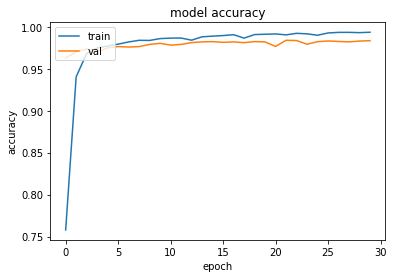

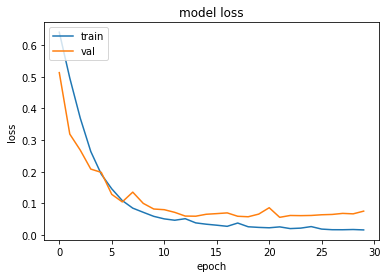

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model = load_model('/content/best_model.h5')
model.load_weights('/content/best_model.h5')
t = next(Val)
x_val = t[0]
y_val = t[1]
model.evaluate(x_val,y_val, verbose=1)

1/1 [==============================] - 2s 2s/step - loss: 0.0499 - accuracy: 0.9803


[0.04986123740673065, 0.98028564453125]

In [ ]:
path_of_training = '/content/drive/MyDrive/Levir-CD/pred'
pred= predGenerator(aug_dict=data_gen_args, train_path=path_of_training, image1_folder ='A', image2_folder='B', mask_folder='label', batch_size=1, save_to_dir= None)
t = next(pred)
X_train = t[0]
Y_train = t[1]
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(x_val, verbose=1)

Found 1 images belonging to 1 classes.
Found 1 images belonging to 1 classes.
Found 1 images belonging to 1 classes.
1/1 [==============================] - 0s 70ms/step


In [ ]:
from PIL import Image
_,h, w, c = preds_train.shape
preds_train = np.reshape(preds_train, (h, w, c))

img = preds_train
h, w, c = img.shape
color_dict = {0: (0),
              1: (255),
              }
# Generate one hot encoded array from predicted output.
for i in range(h):
    for j in range(w):
        # Select the index of max value among the 9 classes.
        argmax_index = np.argmax(img[i, j])
        onehot_arr = np.zeros((2))
        onehot_arr[argmax_index] = 1
        img[i, j, :] = onehot_arr

# Convert OneHotEncoded array to RGB.
def onehot_to_rgb(onehot, color_dict):
    print(onehot.shape)
    single_layer = np.argmax(onehot, axis=-1)
    output = np.zeros(onehot.shape[:2]+(3,) )
    print(output.shape)
    for k in color_dict.keys():
        output[single_layer==k] = color_dict[k]
    return np.uint8(output)
  
y_pred_img = onehot_to_rgb(img,color_dict)

# Get the dimensions of the original image
h, w = 1024,1024

# Generate image and save it.
y_pred_img = y_pred_img[:h, :w, :]
imx = Image.fromarray(y_pred_img)
# Set file path appropriately
imx.save(
    "/content/"+str(1) + ".jpg")
print("Saved...")

(256, 256, 2)
(256, 256, 3)
Saved...
